In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()

In [6]:
print(words[:8])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [52]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}

In [291]:
# build dataset
block_size = 3
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
# emma
# ... ---> e
# ..e ---> m
# .em ---> m
# emm ---> a
# mma ---> .
# olivia
# ... ---> o
# ..o ---> l
# .ol ---> i
# oli ---> v
# liv ---> i
# ivi ---> a
# via ---> .

In [292]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [188]:
# C is a matrix of embeddings of dim = 2
# Each word (char in alphabet -> assoc. w/ dim2 vector)
C = torch.randn((27,2))
C[:2]

tensor([[ 0.2326,  1.1880],
        [-0.2304, -0.5606]])

In [189]:
X[:2]

tensor([[0, 0, 0],
        [0, 0, 5]])

In [190]:
emb = C[X]
emb[:2]

tensor([[[ 0.2326,  1.1880],
         [ 0.2326,  1.1880],
         [ 0.2326,  1.1880]],

        [[ 0.2326,  1.1880],
         [ 0.2326,  1.1880],
         [-0.4565, -0.3454]]])

In [191]:
emb.view(-1,6)[:2] # yay lines up with what we want

tensor([[ 0.2326,  1.1880,  0.2326,  1.1880,  0.2326,  1.1880],
        [ 0.2326,  1.1880,  0.2326,  1.1880, -0.4565, -0.3454]])

In [192]:
W = torch.rand((6,100))
b = torch.rand(100)
h = emb.view(-1,6) @ W + b
h.shape

torch.Size([32, 100])

In [193]:
h

tensor([[ 2.3658,  2.3417,  2.5525,  ...,  3.1226,  1.5774,  3.2040],
        [ 1.4455,  1.3229,  1.4431,  ...,  2.8763,  0.8807,  1.7893],
        [-0.0219,  0.4716,  1.3550,  ...,  0.8436, -0.1669,  0.2259],
        ...,
        [ 1.3718,  1.0726,  0.9706,  ...,  1.2859,  0.4700,  1.9794],
        [ 0.9575,  0.7180,  0.1896,  ...,  1.2350,  0.2434, -0.2742],
        [-1.2576,  0.2493,  0.7507,  ...,  0.1993,  0.4221, -0.6640]])

In [194]:
W2 = torch.rand((100,27))
b2 = torch.rand(27)
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [206]:
# This is not good approach numerical unstability happens if the logit > ~80
# You can take away the max from each one of them but still .. 
# count = logits.exp()
# prob = count / count.sum(1, keepdims=True)

# numerically stable but still ineff... we want CE loss
#prob = F.softmax(logits, dim=-1) 
#loss = -prob[torch.arange(32), Y].log().mean()
#loss
# just do this - doesn't create intermediate tensors saves memory. backward pass is more efficeint 
F.cross_entropy(logits, Y)

tensor(14.3412)

In [ ]:
# serious only # 

In [460]:
# build dataset
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [461]:
Xtr.shape, Ytr.shape

(torch.Size([182778, 3]), torch.Size([182778]))

In [499]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g, requires_grad = True) #rand unfirm dist. (0,1) vs. randn gaussian dist mean 0
W1 = torch.randn((30,200), generator=g, requires_grad = True)
b1 = torch.randn(200, generator=g, requires_grad = True)
W2 = torch.randn((200,27), generator=g, requires_grad = True)
b2 = torch.randn(27, generator=g, requires_grad = True)
params = [C, W1, b1, W2, b2]

In [500]:
sum(p.nelement() for p in params)

11897

In [502]:
loss_i = []
steps_i = []

In [519]:
for i in range(500000):
    # forward pass
    # minibatch (approx. gradient)
    ix = torch.randint(0, Xtr.shape[0], (32,)) # 32 random row index's
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 pytorch infers size, no need to say 32 as it might change, h.shape (32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # update
    for p in params:
        lr = 0.07 # can be found w graph of loss against lr
        p.data += -lr * p.grad # how determine learning rate?
    steps_i.append(i)
    loss_i.append(loss.log10().item())
#print(loss.item()) # this wont be 0 since we have many different starts, ... -> a or ... -> e 

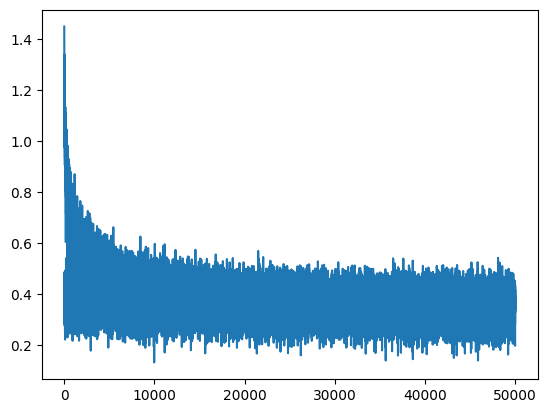

In [505]:
plt.plot(steps_i, loss_i)

In [518]:
# eval on validation set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.39902925491333

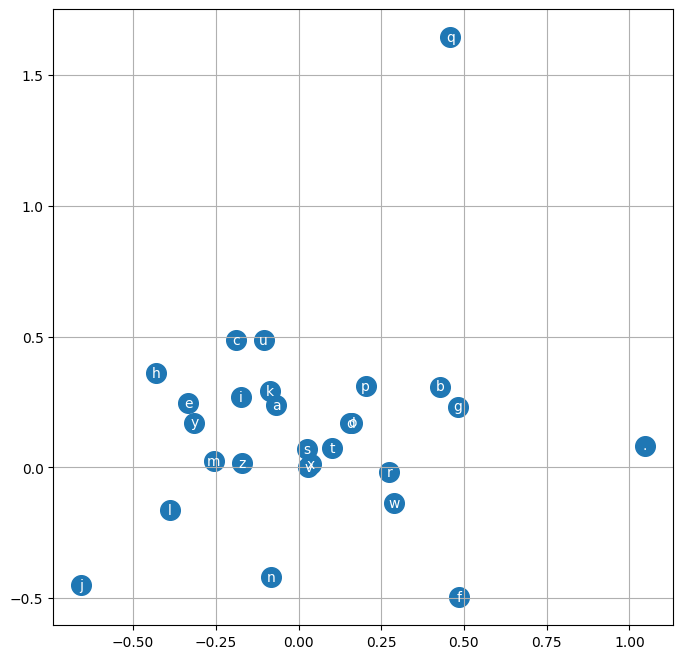

In [507]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')